# TRABAJO FIN DE MASTER - DATOS INCENDIOS
# **Author**: Cristóbal León-Salas
# **Date**: 2025-08-26

# LIBRERIAS

Se cargan las siguietnes librerias:

-  pandas --> Para tablas de datos.
-  numpy --> para cálculos numéricos y para trabajar con matrices y vectores.
-  os --> Para trabajar con directorios, archivos, carpetas,...
-  matplotlib --> Para hacer visualizaciones gráficas básicas e importar imágenes.
-  seaborn --> Para gráficos estadísticos más profesionales y de fácil interpretación.
-  warnings --> Para evitar mensajes de advertencias
-  product -->  Para sacar todas las combinaciones posibles entre los elementos de dos o más listas
-  folium –> Para representación georreferenciada
-  statsmodels.api y statsmodels.discrete.discrete_model --> Para aplciar el método de la binomial negativa
-  statsmodels.genmod.generalized_linear_model --> Para construir modelos GLMs
-  from sklearn.preprocessing --> Se utiliza para normalizar o estandarizar variables numéricas antes de entrenar un modelo.


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from itertools import product
from IPython.display import display
import folium
import matplotlib.image as mpimg
import unicodedata
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import NegativeBinomial
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from sklearn.preprocessing import StandardScaler

# Ignorar el SettingWithCopyWarning
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
sns.set()

# FUNCIONES

## Función normalizar_ascii

In [2]:
def normalizar_ascii(s):
    return (
        unicodedata.normalize("NFKD", s)
        .encode("ascii", "ignore")
        .decode("ascii")
    )

# DATOS DE INCENDIOS

## LECTURA DE DATOS DE INCENDIOS

In [3]:
df_incendios =  pd.read_csv("92_fires-all.csv", sep=",")

In [4]:
df_regions = pd.read_excel("93_eell-extra-codes.xlsx", sheet_name="regions")

In [5]:
df_regions = df_regions.iloc[:, :4]

In [6]:
df_regions.head()

,CODAUTO,Comunidad Autónoma,CPRO,Provincia
0,1,Andalucía,4,Almería
1,1,Andalucía,11,Cádiz
2,1,Andalucía,14,Córdoba
3,1,Andalucía,18,Granada
4,1,Andalucía,21,Huelva


In [7]:
df_incendios.head()

,id,superficie,fecha,lat,lng,latlng_explicit,idcomunidad,idprovincia,idmunicipio,municipio,...,causa_supuesta,causa_desc,muertos,heridos,time_ctrl,time_ext,personal,medios,gastos,perdidas
0,1968290001,14.0,1968-01-01,NaN,NaN,NaN,4,29,0,INDETERMINADO,...,1,40,0,0,0,360,0,0,0,0
1,1968430003,3.0,1968-01-03,NaN,NaN,NaN,2,43,0,INDETERMINADO,...,1,0,0,0,0,60,0,0,0,0
2,1968290006,2.0,1968-01-06,NaN,NaN,NaN,4,29,0,INDETERMINADO,...,1,0,0,0,0,120,0,0,0,0
3,1968120007,8.2,1968-01-07,NaN,NaN,NaN,9,12,0,INDETERMINADO,...,1,20,0,0,0,120,0,0,0,0
4,1968430016,600.0,1968-01-07,NaN,NaN,NaN,2,43,0,INDETERMINADO,...,1,20,0,0,0,1440,35,1,0,0


De esta base de datos me quedaré con:

1. Superficie: Dado que el objeto de este análisis es conocer las dimensiones de los incendios que se producen en las proximidades de la Ciudad de Madrid.
2. idcomunidad: Porque tomaré solo las comunidades próximas a la Ciudad de Madrid, esto es: Castilla-León, Castilla La Mancha y la Comunidad de Madrid.
3. idpovincia: Porque dadas las Comunidades Autónomas anteriores, trataré de eliminar los incendios originados en provincias alejadas de la Ciudad de Madrid.
4. Adaptaré las fechas a las bases de datos que tengo de las emisiones en la Ciudad de Madrid.


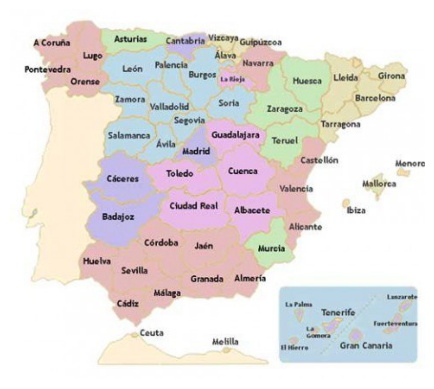

In [8]:
# Cargar imagen
img = mpimg.imread("91_25.08.27_Provincias España.jpg")

# Mostrar imagen
plt.imshow(img)
plt.axis("off")  # quita los ejes
plt.show()

In [9]:
# 1) Listamos provincias cercanas a la Ciudad de Madrid:
provincias_cercanas_nombres = ["Madrid", "Ávila", "Segovia", "Guadalajara", "Toledo", "Cuenca"]

# 2) Normalizamos nombres de provincias para poder comparar de ambas tablas
df_regions["Provincia_norm"] = (
    df_regions["Provincia"]
    .str.normalize("NFKD")
    .str.encode("ascii", errors="ignore")
    .str.decode("ascii")
) # Este código normaliza y limpia los nombres de provincias, lo que facilita comparar cadenas de texto

target_norm = [normalizar_ascii(s) for s in provincias_cercanas_nombres] # Este código crea una versión "limpia" en ASCII de los nombres de provincias, sin acentos ni símbolos raros, para que luego puedan compararse fácilmente con la columna Provincia_norm del Excel.

# 3) Una vez normalizadas, tomamos los códigos CPRO de las provincias cercanas
provincias_cercanas_cod = (
    df_regions[df_regions["Provincia_norm"].isin(target_norm)]["CPRO"]
    .dropna()
    .astype(int)
    .unique()
    .tolist()
)

In [10]:
provincias_cercanas_cod

[5, 40, 16, 19, 45, 28]

Pasamos ahora a prerparar el datafrme de incendios

In [11]:
# --- 1) Convertimos fecha y creamos columna compatible con emisiones
df_incendios_filt = df_incendios.copy()
df_incendios_filt["fecha"] = pd.to_datetime(df_incendios_filt["fecha"], errors="coerce")

# Columna de visualización (string dd-mm-YYYY)
df_incendios_filt["DIA/MES/ANO"] = df_incendios_filt["fecha"].dt.strftime("%d-%m-%Y")

# --- 2) Filtramos por provincias cercanas (robusto ante valores no numéricos)
prov_num = pd.to_numeric(df_incendios_filt["idprovincia"], errors="coerce")
df_incendios_filt = df_incendios_filt[prov_num.isin(provincias_cercanas_cod)]

# --- 3) Reordenamos columnas: fecha al principio, superficie al final
# (y orden cronológico por la columna datetime auxiliar)
nuevo_orden = ["DIA/MES/ANO", "idcomunidad", "idprovincia", "municipio", "superficie", "fecha"]

df_incendios_filt = (
    df_incendios_filt.loc[:, nuevo_orden]
    .sort_values(["fecha", "idprovincia", "municipio"])
    .reset_index(drop=True)
)

# --- 4) Eliminamos la columna fecha
df_incendios_filt = df_incendios_filt.drop(columns=["fecha"])

In [12]:
df_incendios_filt.head()

,DIA/MES/ANO,idcomunidad,idprovincia,municipio,superficie
0,12-01-1968,17,5,INDETERMINADO,1.0
1,17-01-1968,17,5,INDETERMINADO,30.0
2,18-01-1968,17,5,INDETERMINADO,15.0
3,19-01-1968,17,5,INDETERMINADO,3.0
4,30-01-1968,17,5,INDETERMINADO,3.0


In [13]:
df_incendios_filt.tail()

,DIA/MES/ANO,idcomunidad,idprovincia,municipio,superficie
14908,05-08-2022,17,5,STA CRUZ DEL VALLE,1495.32
14909,10-08-2022,17,5,CASILLAS,1.56
14910,21-08-2022,17,5,NAVADIJOS,64.02
14911,27-08-2022,17,5,SOLANA DE ÁVILA,44.09
14912,10-09-2022,17,5,AVILA,1.93


Para ajustarlo a los datos originales de la calidad del aires, filtro los datos de los incendios por todas aquellas fechas que sean superiores al 01 de enero de 2010

In [14]:
# Convertimos la columna a formato datetime
df_incendios_filt["DIA/MES/ANO"] = pd.to_datetime(df_incendios_filt["DIA/MES/ANO"], format="%d-%m-%Y")

In [15]:
df_incendios_filt = df_incendios_filt[df_incendios_filt["DIA/MES/ANO"] > "01-01-2010"]

In [16]:
# Columna de visualización (string dd-mm-YYYY)
df_incendios_filt["DIA/MES/ANO"] = df_incendios_filt["DIA/MES/ANO"].dt.strftime("%d-%m-%Y")

In [17]:
df_incendios_filt.head()

,DIA/MES/ANO,idcomunidad,idprovincia,municipio,superficie
11887,29-01-2010,11,16,ZARZA DE TAJO,1.66
11888,13-02-2010,16,28,ARANJUEZ,9.35
11889,28-02-2010,17,40,ZARZUELA DEL MONTE,2.20
11890,28-02-2010,17,40,ZARZUELA DEL MONTE,1.00
11891,11-03-2010,11,45,"REAL DE SAN VICENTE, EL",4.80


In [18]:
df_incendios_filt.tail()

,DIA/MES/ANO,idcomunidad,idprovincia,municipio,superficie
14908,05-08-2022,17,5,STA CRUZ DEL VALLE,1495.32
14909,10-08-2022,17,5,CASILLAS,1.56
14910,21-08-2022,17,5,NAVADIJOS,64.02
14911,27-08-2022,17,5,SOLANA DE ÁVILA,44.09
14912,10-09-2022,17,5,AVILA,1.93


In [19]:
df_incendios_filt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3026 entries, 11887 to 14912
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DIA/MES/ANO  3026 non-null   object 
 1   idcomunidad  3026 non-null   int64  
 2   idprovincia  3026 non-null   int64  
 3   municipio    3026 non-null   object 
 4   superficie   3026 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 141.8+ KB


Procedo ahora a:

1) Quedarme solo con las columnas "DIA/MES/ANO" y "superficie"
2) Crear instancias nuevas con las fechas que falten desde el 01 de enero de 2010 hastas el último día que tenga el dataframe df_incendios_filt. Estas instancias tendran valores 0 en la variable superficie
3) Agrupar el dataframe por fechas sumando los valores de superficie de una misma fecha (mismo dia).

In [20]:
# Creo una nueva variable con las variables con las que me quiero quedar para el dataframe (la fecha y la superficie en hectáreas que se han quemado en las provincias cercanas de la Ciudad de Madrid:

cols_needed = ["DIA/MES/ANO", "superficie"]

# Por un lado, Vuelvo a pasar la variable DIA/MES/ANO a formato fechas y limpio
df_incendios_filt["DIA/MES/ANO"] = pd.to_datetime(df_incendios_filt["DIA/MES/ANO"], dayfirst=True, errors="coerce")
df_incendios_filt = df_incendios_filt.dropna(subset=["DIA/MES/ANO"]) # Elimino aquellas instancias que tras pasar el filtro anterior son declaradas NA.

# Por otro lado, aseguro que 'superficie' es numérica (NAs -> 0)
df_incendios_filt["superficie"] = pd.to_numeric(df_incendios_filt["superficie"], errors="coerce").fillna(0)

# Agrupo por fecha sumando la superficie de un mismo día
df_incendios_filt = (
    df_incendios_filt.groupby("DIA/MES/ANO", as_index=True)["superficie"]
      .sum()
      .to_frame() # Convierte una serie en un DataFrame de una columna.
      .sort_index()
)

In [21]:
# Relleno fechas faltantes desde 2010-01-01 hasta el último día presente en los datos
start_date = pd.Timestamp("2010-01-01")
end_date = df_incendios_filt.index.max()

In [22]:
# Relleno todo el rango desde el 01 de enero de 2010 hasta el ultimo día del dataframe
full_range = pd.date_range(start=start_date, end=end_date, freq="D")
df_incendios_filt = (
    df_incendios_filt.reindex(full_range)            # añade fechas faltantes
              .rename_axis("DIA/MES/ANO")
              .fillna({"superficie": 0})      # superficie = 0 en fechas añadidas
              .reset_index()
)

# Formatear fecha de vuelta a dd-mm-YYYY (opcional, para consistencia con otros datos)
df_incendios_filt["DIA/MES/ANO"] = df_incendios_filt["DIA/MES/ANO"].dt.strftime("%d-%m-%Y")

In [23]:
df_incendios_filt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4636 entries, 0 to 4635
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DIA/MES/ANO  4636 non-null   object 
 1   superficie   4636 non-null   float64
dtypes: float64(1), object(1)
memory usage: 72.6+ KB


In [24]:
df_incendios_filt["DIA/MES/ANO"] = pd.to_datetime(df_incendios_filt["DIA/MES/ANO"], dayfirst=True, errors="coerce")

In [25]:
df_incendios_filt.describe(include="all")

,DIA/MES/ANO,superficie
count,4636,4636.000000
mean,2016-05-06 12:00:00,18.814374
min,2010-01-01 00:00:00,0.000000
25%,2013-03-04 18:00:00,0.000000
50%,2016-05-06 12:00:00,0.000000
75%,2019-07-09 06:00:00,2.400000
max,2022-09-10 00:00:00,21272.670000
std,NaN,339.961642


In [26]:
df_incendios_filt.head()

,DIA/MES/ANO,superficie
0,2010-01-01,0.0
1,2010-01-02,0.0
2,2010-01-03,0.0
3,2010-01-04,0.0
4,2010-01-05,0.0


In [27]:
df_incendios_filt.tail()

,DIA/MES/ANO,superficie
4631,2022-09-06,0.00
4632,2022-09-07,0.00
4633,2022-09-08,0.00
4634,2022-09-09,0.00
4635,2022-09-10,1.93


In [28]:
df_incendios_filt.isna().sum()

DIA/MES/ANO    0
superficie     0
dtype: int64

# ESTIMACIÓN DATOS FALTANTES

## MODELO HURDLE

Para la estimación de los datos faltantes, desde 10 de noviembre de 2022 al 30 de junio de 2025, usaremos el modelo HURDLE.

¿Por qué el modelo Hurdle?

Un modelo hurdle es un tipo de modelo estadístico que se utiliza para analizar datos con una alta proporción de valores cero, como es nuestro caso. Este modelo se compone de dos partes:

1. Una parte que modela la probabilidad de que un valor sea cero, utilizando un modelo binomial, logit o probit.
2. Una parte que modela la probabilidad de que el valor no sea cero, utilizando un modelo de conteo, como Poisson o negativa binomial.
   
Los modelos hurdle son útiles para entender la influencia de factores que pueden afectar tanto los valores cero como los valores positivos en un conjunto de datos.

Para nuestro dataset, construiremos un modelo “hurdle” de dos partes para estimar superficie quemada por día a partir de variables meteorológicas: 

- Primero modelaremos la probabilidad de que haya incendio (ocurrencia). Con función Logit
- Luego modelaremos la superficie condicional a que sí haya incendio (intensidad). Con GLM Gamma con link log
- Finalmente, combinaremos ambas para obtener el valor esperado y rellenar estimaciones cuando falte el dato original.

Por tanto los pasos que llevaré a cabo para la estimación de los datos faltantes será:

1. Cargar datos meteorológicos.
2. Hacer un merge con ambos dataframes.
3. Agrupar por fechas.
4. Aplicar el método "hurdle".


### LECTURA DATOS METEOROLÓGICOS

In [29]:
df_met = pd.read_parquet("02_DATASET_FINAL.parquet", engine="pyarrow")

In [30]:
df_met.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430160 entries, 0 to 430159
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   DIA/MES/ANO              430160 non-null  datetime64[ns]
 1   ZONA_ESTACION            430160 non-null  category      
 2   MAGNITUD                 430160 non-null  int64         
 3   MEDICION_ugm3            385174 non-null  float64       
 4   TEMPERATURA_MAX (°C)     430160 non-null  float64       
 5   TEMPERATURA_MIN (°C)     430160 non-null  float64       
 6   TEMPERATURA_MED (°C)     430160 non-null  float64       
 7   PRECIPITACIONES (mm)     430160 non-null  float64       
 8   HUMEDAD_MAX (%)          430160 non-null  float64       
 9   HUMEDAD_MIN (%)          430160 non-null  float64       
 10  HUMEDAD_MED (%)          430160 non-null  float64       
 11  NIEVE (cm)               430160 non-null  float64       
 12  VIENTO_MAX_10 (k

### ELIMINACIÓN VARIABLES NO METEOROLÓGICAS

In [31]:
cols_to_drop = ["ZONA_ESTACION", "MAGNITUD", "MEDICION_ugm3"]
df_met = df_met.drop(columns=cols_to_drop, errors="ignore")

In [32]:
df_met.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430160 entries, 0 to 430159
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   DIA/MES/ANO              430160 non-null  datetime64[ns]
 1   TEMPERATURA_MAX (°C)     430160 non-null  float64       
 2   TEMPERATURA_MIN (°C)     430160 non-null  float64       
 3   TEMPERATURA_MED (°C)     430160 non-null  float64       
 4   PRECIPITACIONES (mm)     430160 non-null  float64       
 5   HUMEDAD_MAX (%)          430160 non-null  float64       
 6   HUMEDAD_MIN (%)          430160 non-null  float64       
 7   HUMEDAD_MED (%)          430160 non-null  float64       
 8   NIEVE (cm)               430160 non-null  float64       
 9   VIENTO_MAX_10 (km/h)     430160 non-null  float64       
 10  VIENTO_MIN_10 (km/h)     430160 non-null  float64       
 11  VIENTO_MED_10 (km/h)     430160 non-null  float64       
 12  VIENTO_DIR_10 (°

In [33]:
df_met.describe(include="all")

,DIA/MES/ANO,TEMPERATURA_MAX (°C),TEMPERATURA_MIN (°C),TEMPERATURA_MED (°C),PRECIPITACIONES (mm),HUMEDAD_MAX (%),HUMEDAD_MIN (%),HUMEDAD_MED (%),NIEVE (cm),VIENTO_MAX_10 (km/h),...,VIENTO_MAX_100 (km/h),VIENTO_MIN_100 (km/h),VIENTO_MED_100 (km/h),VIENTO_DIR_100 (°),NUBES (%),HORAS_SOL (min),RADIACION_SOLAR (W/mÂ²),PRESION_MAX (hPa),PRESION_MIN (hPa),PRESION_MED (hPa)
count,430160,430160.000000,430160.000000,430160.000000,430160.000000,430160.000000,430160.000000,430160.000000,430160.000000,430160.000000,...,430160.000000,430160.000000,430160.000000,430160.000000,430160.000000,430160.000000,430160.000000,430160.000000,430160.000000,430160.000000
mean,2017-09-30 12:00:00,21.175853,9.328403,15.182447,1.160674,77.569044,38.744659,57.831568,0.013518,13.767517,...,22.340934,6.043979,13.873680,170.916530,29.014741,515.065573,4800.167940,1020.155645,1014.870995,1017.496497
min,2010-01-01 00:00:00,0.313577,-8.606422,-2.273089,0.000000,23.544718,3.755852,15.999530,0.000000,4.334974,...,5.804825,0.000000,2.704543,0.000000,0.000000,0.000000,208.000000,993.300000,981.600000,986.708300
25%,2013-11-15 18:00:00,13.453577,4.001077,8.581181,0.000000,65.512060,22.504036,41.365525,0.000000,9.504272,...,17.283749,2.036468,9.596947,61.903532,7.117709,341.387027,2627.000000,1015.900000,1010.700000,1013.383465
50%,2017-09-30 12:00:00,20.103577,8.978578,14.124826,0.000000,82.027065,35.613806,58.455086,0.000000,12.979984,...,21.694288,4.198285,12.686111,203.249815,21.972920,547.991000,4788.000000,1019.400000,1014.100000,1016.787470
75%,2021-08-15 06:00:00,28.856077,14.836077,21.903578,0.300000,90.825645,51.709024,73.403296,0.000000,17.015474,...,26.282465,8.350138,16.987114,242.273327,45.892708,707.436838,6986.250000,1024.200000,1019.000000,1021.401030
max,2025-06-30 00:00:00,40.993576,25.183577,32.575665,46.600002,100.072180,94.439926,97.250730,16.799997,39.279613,...,62.654480,36.044970,44.454310,360.000000,99.791664,907.466700,8987.000000,1045.000000,1041.500000,1042.633200
std,NaN,8.948036,6.749765,7.902224,3.581572,15.846928,19.125343,18.678527,0.293369,5.339885,...,7.514791,5.520373,6.085764,104.492332,25.813514,241.175118,2367.300671,6.565325,7.021678,6.720450


In [34]:
df_met.isna().sum()

DIA/MES/ANO                0
TEMPERATURA_MAX (°C)       0
TEMPERATURA_MIN (°C)       0
TEMPERATURA_MED (°C)       0
PRECIPITACIONES (mm)       0
HUMEDAD_MAX (%)            0
HUMEDAD_MIN (%)            0
HUMEDAD_MED (%)            0
NIEVE (cm)                 0
VIENTO_MAX_10 (km/h)       0
VIENTO_MIN_10 (km/h)       0
VIENTO_MED_10 (km/h)       0
VIENTO_DIR_10 (°)          0
VIENTO_MAX_100 (km/h)      0
VIENTO_MIN_100 (km/h)      0
VIENTO_MED_100 (km/h)      0
VIENTO_DIR_100 (°)         0
NUBES (%)                  0
HORAS_SOL (min)            0
RADIACION_SOLAR (W/mÂ²)    0
PRESION_MAX (hPa)          0
PRESION_MIN (hPa)          0
PRESION_MED (hPa)          0
dtype: int64

### MERGE AMBOS DATAFRAMES

In [35]:
# Aseguro formato de fecha en ambos dataframes
df_incendios_filt["DIA/MES/ANO"] = pd.to_datetime(df_incendios_filt["DIA/MES/ANO"], errors="coerce")
df_met["DIA/MES/ANO"] = pd.to_datetime(df_met["DIA/MES/ANO"], errors="coerce")

# Merge por fecha (inner: solo intersección, left: todos los incendios con meteo si hay)
df_incendios_filt = pd.merge(
    df_met,
    df_incendios_filt,
    on="DIA/MES/ANO",
    how="left"   # cambia a "inner" si quieres solo las fechas comunes
)

### AGRUPAR POR FECHA

In [36]:
# 0) Aseguro que no hay fechas nulas
df_incendios_filt = df_incendios_filt.dropna(subset=["DIA/MES/ANO"])

# 1) Selecciono las columnas numéricas para promediar
numeric_cols = df_incendios_filt.select_dtypes(include="number").columns

# 2) Agrupo por fecha y calculo media de todas las columnas numéricas
df_incendios_filt = (
    df_incendios_filt
      .groupby("DIA/MES/ANO", as_index=False)[numeric_cols]
      .mean()
      .sort_values("DIA/MES/ANO")
)

In [37]:
df_incendios_filt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5660 entries, 0 to 5659
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   DIA/MES/ANO              5660 non-null   datetime64[ns]
 1   TEMPERATURA_MAX (°C)     5660 non-null   float64       
 2   TEMPERATURA_MIN (°C)     5660 non-null   float64       
 3   TEMPERATURA_MED (°C)     5660 non-null   float64       
 4   PRECIPITACIONES (mm)     5660 non-null   float64       
 5   HUMEDAD_MAX (%)          5660 non-null   float64       
 6   HUMEDAD_MIN (%)          5660 non-null   float64       
 7   HUMEDAD_MED (%)          5660 non-null   float64       
 8   NIEVE (cm)               5660 non-null   float64       
 9   VIENTO_MAX_10 (km/h)     5660 non-null   float64       
 10  VIENTO_MIN_10 (km/h)     5660 non-null   float64       
 11  VIENTO_MED_10 (km/h)     5660 non-null   float64       
 12  VIENTO_DIR_10 (°)        5660 non-

In [38]:
df_incendios_filt.describe(include="all")

,DIA/MES/ANO,TEMPERATURA_MAX (°C),TEMPERATURA_MIN (°C),TEMPERATURA_MED (°C),PRECIPITACIONES (mm),HUMEDAD_MAX (%),HUMEDAD_MIN (%),HUMEDAD_MED (%),NIEVE (cm),VIENTO_MAX_10 (km/h),...,VIENTO_MIN_100 (km/h),VIENTO_MED_100 (km/h),VIENTO_DIR_100 (°),NUBES (%),HORAS_SOL (min),RADIACION_SOLAR (W/mÂ²),PRESION_MAX (hPa),PRESION_MIN (hPa),PRESION_MED (hPa),superficie
count,5660,5660.000000,5660.000000,5660.000000,5660.000000,5660.000000,5660.000000,5660.000000,5660.000000,5660.000000,...,5660.000000,5660.000000,5660.000000,5660.000000,5660.000000,5660.000000,5660.000000,5660.000000,5660.000000,4636.000000
mean,2017-09-30 12:00:00,21.175853,9.328403,15.182447,1.160674,77.569044,38.744659,57.831568,0.013518,13.767517,...,6.043979,13.873680,170.916530,29.014741,515.065573,4800.167940,1020.155645,1014.870995,1017.496497,18.814374
min,2010-01-01 00:00:00,0.313577,-8.606422,-2.273089,0.000000,23.544718,3.755852,15.999530,0.000000,4.334974,...,0.000000,2.704543,0.000000,0.000000,0.000000,208.000000,993.300000,981.600000,986.708300,0.000000
25%,2013-11-15 18:00:00,13.453577,4.001077,8.581181,0.000000,65.512060,22.504036,41.365525,0.000000,9.504272,...,2.036468,9.596947,61.903532,7.117709,341.387027,2627.000000,1015.900000,1010.700000,1013.383465,0.000000
50%,2017-09-30 12:00:00,20.103577,8.978578,14.124826,0.000000,82.027065,35.613806,58.455086,0.000000,12.979984,...,4.198285,12.686111,203.249815,21.972919,547.991000,4788.000000,1019.400000,1014.100000,1016.787470,0.000000
75%,2021-08-15 06:00:00,28.856077,14.836077,21.903578,0.300000,90.825645,51.709024,73.403296,0.000000,17.015474,...,8.350138,16.987114,242.273327,45.892708,707.436838,6986.250000,1024.200000,1019.000000,1021.401030,2.400000
max,2025-06-30 00:00:00,40.993576,25.183577,32.575665,46.600002,100.072180,94.439926,97.250730,16.799997,39.279613,...,36.044970,44.454310,360.000000,99.791664,907.466700,8987.000000,1045.000000,1041.500000,1042.633200,21272.670000
std,NaN,8.948816,6.750353,7.902913,3.581884,15.848310,19.127011,18.680155,0.293394,5.340351,...,5.520854,6.086295,104.501443,25.815765,241.196145,2367.507072,6.565898,7.022290,6.721036,339.961642


In [39]:
df_incendios_filt.head()

,DIA/MES/ANO,TEMPERATURA_MAX (°C),TEMPERATURA_MIN (°C),TEMPERATURA_MED (°C),PRECIPITACIONES (mm),HUMEDAD_MAX (%),HUMEDAD_MIN (%),HUMEDAD_MED (%),NIEVE (cm),VIENTO_MAX_10 (km/h),...,VIENTO_MIN_100 (km/h),VIENTO_MED_100 (km/h),VIENTO_DIR_100 (°),NUBES (%),HORAS_SOL (min),RADIACION_SOLAR (W/mÂ²),PRESION_MAX (hPa),PRESION_MIN (hPa),PRESION_MED (hPa),superficie
0,2010-01-01,8.833577,4.033577,5.879828,0.100000,81.779030,63.816715,75.354380,0.0,29.671074,...,18.043148,28.416998,238.27025,55.933334,227.164660,1329.0,1017.5,1007.3,1011.06665,0.0
1,2010-01-02,7.433577,1.633577,5.113994,0.000000,91.992530,78.912926,85.837580,0.0,6.840000,...,1.800000,8.827096,214.30350,59.087498,92.617860,1262.0,1022.7,1017.6,1020.66656,0.0
2,2010-01-03,6.893577,3.553577,5.551910,3.200000,95.715294,83.991780,91.829384,0.0,6.297428,...,1.835647,7.187243,182.42377,89.041664,40.621723,725.0,1020.7,1015.5,1018.64580,0.0
3,2010-01-04,8.423577,5.983577,7.413578,10.900001,97.863980,91.812260,95.082640,0.0,7.568566,...,6.877790,10.584868,116.39993,90.250000,0.676768,498.0,1014.8,1001.5,1007.65010,0.0
4,2010-01-05,10.783577,6.013578,8.091077,1.900000,96.731870,69.086680,83.976160,0.0,7.636753,...,4.510787,10.179250,343.52313,74.708336,214.730650,1436.0,1004.4,1000.0,1001.49994,0.0


In [40]:
df_incendios_filt.tail()

,DIA/MES/ANO,TEMPERATURA_MAX (°C),TEMPERATURA_MIN (°C),TEMPERATURA_MED (°C),PRECIPITACIONES (mm),HUMEDAD_MAX (%),HUMEDAD_MIN (%),HUMEDAD_MED (%),NIEVE (cm),VIENTO_MAX_10 (km/h),...,VIENTO_MIN_100 (km/h),VIENTO_MED_100 (km/h),VIENTO_DIR_100 (°),NUBES (%),HORAS_SOL (min),RADIACION_SOLAR (W/mÂ²),PRESION_MAX (hPa),PRESION_MIN (hPa),PRESION_MED (hPa),superficie
5655,2025-06-26,32.203580,14.313578,24.527327,0.0000,74.444820,19.840967,41.856327,0.0,6.725354,...,3.826853,6.660889,153.868990,0.000000,906.466600,8618.000000,1020.60,1017.900000,1019.150100,NaN
5656,2025-06-27,35.553577,18.293577,27.409828,0.0000,55.928905,13.678853,33.797398,0.0,8.225035,...,3.396233,8.696938,103.126854,0.012500,906.133300,8633.000000,1023.80,1019.600000,1021.629100,NaN
5657,2025-06-28,37.423576,19.893578,28.952332,0.0000,49.371860,16.764837,32.478390,0.0,11.525623,...,2.520000,10.318219,44.487520,7.108334,862.887200,8412.000000,1023.90,1018.900000,1021.533450,NaN
5658,2025-06-29,37.433580,22.563578,30.162743,0.4000,47.426750,16.073263,29.906588,0.0,19.803272,...,4.452954,17.080273,22.641602,11.933334,779.573800,8031.000000,1021.80,1016.200000,1019.429140,NaN
5659,2025-06-30,31.605661,17.139827,24.912848,0.2125,60.474367,21.010745,37.881444,0.0,15.259512,...,5.698363,14.496898,186.876944,11.956424,776.895268,7737.541667,1017.15,1012.433333,1014.920519,NaN


In [41]:
df_incendios_filt.isna().sum()

DIA/MES/ANO                   0
TEMPERATURA_MAX (°C)          0
TEMPERATURA_MIN (°C)          0
TEMPERATURA_MED (°C)          0
PRECIPITACIONES (mm)          0
HUMEDAD_MAX (%)               0
HUMEDAD_MIN (%)               0
HUMEDAD_MED (%)               0
NIEVE (cm)                    0
VIENTO_MAX_10 (km/h)          0
VIENTO_MIN_10 (km/h)          0
VIENTO_MED_10 (km/h)          0
VIENTO_DIR_10 (°)             0
VIENTO_MAX_100 (km/h)         0
VIENTO_MIN_100 (km/h)         0
VIENTO_MED_100 (km/h)         0
VIENTO_DIR_100 (°)            0
NUBES (%)                     0
HORAS_SOL (min)               0
RADIACION_SOLAR (W/mÂ²)       0
PRESION_MAX (hPa)             0
PRESION_MIN (hPa)             0
PRESION_MED (hPa)             0
superficie                 1024
dtype: int64

Saco el valor menor distinto de 0 de la variable "superficie"

In [42]:
# Filtramos los valores distintos de 0
df_nonzero = df_incendios_filt[df_incendios_filt["superficie"] != 0]

# Obtenemos el valor mínimo distinto de 0
min_val_sup = df_nonzero["superficie"].min()

### APLICACIÓN MÉTODO "HURDLE"

Procedemos con el método hurdle descrito anteriormente ante la gran cantidad de valores 0 que tiene la variable dependiente.

Un punto IMPORTANTE es indicar que para la ejecución de los modelos NO se va a considerar la variable temporal

In [43]:

# ---------------- Configuración ----------------
DATE_COL = "DIA/MES/ANO" # Variable temporal
TARGET   = "superficie" # Variable objetivo o dependiente
FEATURES_WANTED = [
    "TEMPERATURA_MED (°C)", 
    "PRECIPITACIONES (mm)",
    "HUMEDAD_MED (%)",
    "VIENTO_MED_10 (km/h)",
    "VIENTO_MED_100 (km/h)",
] # Variables dependiente. Me quedo solo con estas para evitar la multicolinealidad.

# ------------------------------------------------

# 0) Partimos de df_incendios_filt ya mergeado (incendios + meteo)
df = df_incendios_filt.copy()
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce") # Nos aseguramos que la variable "DATE_COL" esté declarada como temporal

# 1) Verifico que existen las columnas pedidas
missing = [c for c in FEATURES_WANTED if c not in df.columns]
if missing:
    raise ValueError(f"Faltan columnas en el DataFrame: {missing}")

features = FEATURES_WANTED

# 2) Conjuntos para entrenamiento

# Ocurrencia: no NA en y ni en X
df_occ = df.dropna(subset=[TARGET] + features).copy() # Me aseguro que no se toma ningún valor NA ni en la variable TARGET ni en las variables independientes
df_occ["y_bin"] = (df_occ[TARGET] > 0).astype(int) # y_bin = 1 si superficie > 0, si no 0.

# Intensidad: solo casos con evento (y>0)
df_int = df_occ[df_occ[TARGET] > 0].copy() # Tomo conjunto de datos que tienen superficie mayor que 0.

# 3) Estandarización (mejora estabilidad numérica). Distribuciones y escalas efectivas pueden diferir entre subconjuntos. Se evita que un conjunto con valores sobredimensionados dominen la regresion. Muy útiles para modelos lineales
scaler_occ = StandardScaler()
scaler_int = StandardScaler()

X_occ_raw = df_occ[features] # Definición del conjunto de datos de la variables independientes en el dataframe df_occ
X_int_raw = df_int[features] # Definición del conjunto de datos de la variables independientes en el dataframe df_int

# Se estandarizan las variables de ambos conjuntos de datos:

X_occ_scaled = pd.DataFrame(
    scaler_occ.fit_transform(X_occ_raw),
    columns=features, index=X_occ_raw.index
)
X_int_scaled = pd.DataFrame(
    scaler_int.fit_transform(X_int_raw),
    columns=features, index=X_int_raw.index
)

# 4) Matrices de diseño
X_occ = sm.add_constant(X_occ_scaled, has_constant="add") # Se añade constante (intercepto) al conjunto estandarizado de las variables independientes.
y_occ = df_occ["y_bin"] 

X_int = sm.add_constant(X_int_scaled, has_constant="add") # Se añade constante (intercepto) al conjunto estandarizado de las variables independientes cuando TARGET > 0
y_int = df_int[TARGET].astype(float).clip(lower=1e-9)  # Gamma exige y>0 (estrictamente mayores que 0). Si algún valor es menor que 1e-9 (es decir, 0 o negativo), se reemplaza por 1e-9

# 5) Modelos
# 5.1) Logístico (ocurrencia)
logit_res = sm.Logit(y_occ, X_occ).fit(disp=False) # Porque queremos converitr scores lineales en probabilidades de claisificacion binaria

# 5.2) Intensidad: GLM Gamma con link Log (con fallback a OLS log1p)

# Se aplica GLM Gamma con link log porque:
# 1) superficie es continua y estricatamente positiva. Se aplic anteriormente el clip.
# 2) Sesgada a la derecha.
# 3) Varianza creciente con la media.
# 4) Usa el link logarítmico, que transforma la relación en multiplicativa.

# Modelo de regresión lineal ordinaria: OLS log1p:
# 1) Transforma y_int con log1p para suavizar y estabilizar.
# 2) Ajusta un modelo OLS sobre esa transformación
# 3) Predice en escala logarítmica, y luego revierte con expm1(...) para volver a la escala original.


use_gamma = True
try:  # Comprobación de estabilidad: si parámetros no son finitos o hay excepción, hace fallback.
    gamma_res = sm.GLM(y_int, X_int, family=families.Gamma(link=families.links.Log())).fit() # Modelo más adecaudo para nuestro caso
    if np.any(~np.isfinite(gamma_res.params.values)):
        raise RuntimeError("Gamma params not finite.")
except Exception:
    use_gamma = False
    y_int_log = np.log1p(y_int)
    ols_res = sm.OLS(y_int_log, X_int).fit() # Alternativa más robusta. Modelo de regresión lineal ordinaria

print("¿Se usó Gamma?", use_gamma)

# 6) Predicción para todas las filas
# Rellenamos NA en X con la mediana (antes de escalar), y aplicamos los mismos scalers
feature_medians = df_occ[features].median()
X_all_raw = df[features].fillna(feature_medians)

# Escalado con los mismos parámetros de entrenamiento
X_all_scaled_occ = pd.DataFrame(scaler_occ.transform(X_all_raw), columns=features, index=X_all_raw.index)
X_all_occ = sm.add_constant(X_all_scaled_occ, has_constant="add")

p_occ = np.clip(logit_res.predict(X_all_occ), 0.0, 1.0)

X_all_scaled_int = pd.DataFrame(scaler_int.transform(X_all_raw), columns=features, index=X_all_raw.index)
X_all_int = sm.add_constant(X_all_scaled_int, has_constant="add")

if use_gamma:
    mu_pos = gamma_res.predict(X_all_int).clip(lower=1e-9)
else:
    mu_log = ols_res.predict(X_all_int)
    mu_pos = np.expm1(mu_log) # Revierte la conversion logaritmica
    mu_pos = np.asarray(mu_pos).clip(min=1e-9)

# Valor esperado (hurdle)
y_expected = (p_occ * mu_pos).astype(float)

# 7) Salidas
df["prob_ocurrencia"]      = p_occ
df["superficie_cond>0"]    = mu_pos
df["superficie_expected"]  = y_expected
df["superficie_estimada"]  = df[TARGET].where(df[TARGET].notna(), df["superficie_expected"])
df["superficie_estimada"]  = df["superficie_estimada"].clip(lower=0)

df_out = df.sort_values(DATE_COL).reset_index(drop=True)
print(df_out[[DATE_COL, TARGET, "prob_ocurrencia", "superficie_cond>0", "superficie_expected", "superficie_estimada"]].tail(10))

# Si quieres, devuelve al objeto principal:
df_incendios_filt = df_out


¿Se usó Gamma? False
     DIA/MES/ANO  superficie  prob_ocurrencia  superficie_cond>0  \
5650  2025-06-21         NaN         0.661233          10.990507   
5651  2025-06-22         NaN         0.589476           9.521700   
5652  2025-06-23         NaN         0.570511           8.742943   
5653  2025-06-24         NaN         0.543935           9.086625   
5654  2025-06-25         NaN         0.310614           8.188295   
5655  2025-06-26         NaN         0.588721           8.087118   
5656  2025-06-27         NaN         0.693312          10.348059   
5657  2025-06-28         NaN         0.650854           9.828097   
5658  2025-06-29         NaN         0.640287          11.175427   
5659  2025-06-30         NaN         0.627630          10.130889   

      superficie_expected  superficie_estimada  
5650             7.267284             7.267284  
5651             5.612810             5.612810  
5652             4.987944             4.987944  
5653             4.942534         

C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\genmod\families\links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\genmod\families\family.py:775: RuntimeWarning: invalid value encountered in divide
  resid_dev = -np.log(endog_mu) + (endog - mu) / mu
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:897: RuntimeWarning: overflow encountered in power
  resid = np.power(self.endog - mu, 2) * self.iweights
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\genmod\families\varfuncs.py:104: RuntimeWarning: overflow encountered in power
  return np.power(np.fabs(mu), self.power)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:898: RuntimeWarning: divide by zero encountered in divide
  return np.sum(resid / self.family.variance(mu)) / self.df_resid
C:\Users\rosal\

Dado que el modelo Gamma daba muchos problemas, se han estimado los valores mediante el modelo de regresión lineal ordinaria: OLS log1p

In [44]:
df_incendios_filt.head()

,DIA/MES/ANO,TEMPERATURA_MAX (°C),TEMPERATURA_MIN (°C),TEMPERATURA_MED (°C),PRECIPITACIONES (mm),HUMEDAD_MAX (%),HUMEDAD_MIN (%),HUMEDAD_MED (%),NIEVE (cm),VIENTO_MAX_10 (km/h),...,HORAS_SOL (min),RADIACION_SOLAR (W/mÂ²),PRESION_MAX (hPa),PRESION_MIN (hPa),PRESION_MED (hPa),superficie,prob_ocurrencia,superficie_cond>0,superficie_expected,superficie_estimada
0,2010-01-01,8.833577,4.033577,5.879828,0.100000,81.779030,63.816715,75.354380,0.0,29.671074,...,227.164660,1329.0,1017.5,1007.3,1011.06665,0.0,0.091381,3.118642,0.284985,0.0
1,2010-01-02,7.433577,1.633577,5.113994,0.000000,91.992530,78.912926,85.837580,0.0,6.840000,...,92.617860,1262.0,1022.7,1017.6,1020.66656,0.0,0.042070,1.101596,0.046344,0.0
2,2010-01-03,6.893577,3.553577,5.551910,3.200000,95.715294,83.991780,91.829384,0.0,6.297428,...,40.621723,725.0,1020.7,1015.5,1018.64580,0.0,0.025298,0.929558,0.023516,0.0
3,2010-01-04,8.423577,5.983577,7.413578,10.900001,97.863980,91.812260,95.082640,0.0,7.568566,...,0.676768,498.0,1014.8,1001.5,1007.65010,0.0,0.013244,1.201219,0.015909,0.0
4,2010-01-05,10.783577,6.013578,8.091077,1.900000,96.731870,69.086680,83.976160,0.0,7.636753,...,214.730650,1436.0,1004.4,1000.0,1001.49994,0.0,0.044394,1.452383,0.064478,0.0


In [45]:
df_rango = df_incendios_filt[(df_incendios_filt["DIA/MES/ANO"] >= "2024-12-15") & (df_incendios_filt["DIA/MES/ANO"] <= "2025-02-15")]

# Selecciono solo las columnas que me interesa mostrar
print(df_rango[["DIA/MES/ANO", "superficie_estimada"]])

     DIA/MES/ANO  superficie_estimada
5462  2024-12-15             0.119618
5463  2024-12-16             0.212892
5464  2024-12-17             0.329703
5465  2024-12-18             0.174561
5466  2024-12-19             0.055473
...          ...                  ...
5520  2025-02-11             0.139120
5521  2025-02-12             0.292675
5522  2025-02-13             0.519453
5523  2025-02-14             0.372530
5524  2025-02-15             0.558199

[63 rows x 2 columns]


In [46]:
df_incendios_filt.isna().sum()

DIA/MES/ANO                   0
TEMPERATURA_MAX (°C)          0
TEMPERATURA_MIN (°C)          0
TEMPERATURA_MED (°C)          0
PRECIPITACIONES (mm)          0
HUMEDAD_MAX (%)               0
HUMEDAD_MIN (%)               0
HUMEDAD_MED (%)               0
NIEVE (cm)                    0
VIENTO_MAX_10 (km/h)          0
VIENTO_MIN_10 (km/h)          0
VIENTO_MED_10 (km/h)          0
VIENTO_DIR_10 (°)             0
VIENTO_MAX_100 (km/h)         0
VIENTO_MIN_100 (km/h)         0
VIENTO_MED_100 (km/h)         0
VIENTO_DIR_100 (°)            0
NUBES (%)                     0
HORAS_SOL (min)               0
RADIACION_SOLAR (W/mÂ²)       0
PRESION_MAX (hPa)             0
PRESION_MIN (hPa)             0
PRESION_MED (hPa)             0
superficie                 1024
prob_ocurrencia               0
superficie_cond>0             0
superficie_expected           0
superficie_estimada           0
dtype: int64

In [47]:
df_incendios_def = df_incendios_filt[["DIA/MES/ANO", "superficie_estimada"]].copy()

print(df_incendios_def.head())
print(df_incendios_def.shape)

  DIA/MES/ANO  superficie_estimada
0  2010-01-01                  0.0
1  2010-01-02                  0.0
2  2010-01-03                  0.0
3  2010-01-04                  0.0
4  2010-01-05                  0.0
(5660, 2)


In [48]:
df_incendios_def = df_incendios_def.rename(columns={"superficie_estimada": "Superficie_incendiada_HA"})

Como los valores estimados no contienen tantos 0 como los históricos, voy a tomar como 0 todos aquellos valores estimados que resulten menores del menor de los valores históricos distintos de 0.

In [49]:
# Sustituir por 0 todos los valores menores que min_val en df2["otra_variable"]
df_incendios_def.loc[df_incendios_def["Superficie_incendiada_HA"] < min_val_sup, "Superficie_incendiada_HA"] = 0

In [50]:
df_rango = df_incendios_def[(df_incendios_def["DIA/MES/ANO"] >= "2024-01-15") & (df_incendios_def["DIA/MES/ANO"] <= "2024-02-15")]

print(df_rango)

     DIA/MES/ANO  Superficie_incendiada_HA
5127  2024-01-15                       0.0
5128  2024-01-16                       0.0
5129  2024-01-17                       0.0
5130  2024-01-18                       0.0
5131  2024-01-19                       0.0
5132  2024-01-20                       0.0
5133  2024-01-21                       0.0
5134  2024-01-22                       0.0
5135  2024-01-23                       0.0
5136  2024-01-24                       0.0
5137  2024-01-25                       0.0
5138  2024-01-26                       0.0
5139  2024-01-27                       0.0
5140  2024-01-28                       0.0
5141  2024-01-29                       0.0
5142  2024-01-30                       0.0
5143  2024-01-31                       0.0
5144  2024-02-01                       0.0
5145  2024-02-02                       0.0
5146  2024-02-03                       0.0
5147  2024-02-04                       0.0
5148  2024-02-05                       0.0
5149  2024-

In [51]:
df_rango = df_incendios_def[(df_incendios_def["DIA/MES/ANO"] >= "2024-07-15") & (df_incendios_def["DIA/MES/ANO"] <= "2024-08-15")]

print(df_rango)

     DIA/MES/ANO  Superficie_incendiada_HA
5309  2024-07-15                  5.432671
5310  2024-07-16                  6.680471
5311  2024-07-17                  8.320768
5312  2024-07-18                 11.512873
5313  2024-07-19                 11.695625
5314  2024-07-20                  9.958202
5315  2024-07-21                  6.714601
5316  2024-07-22                 10.873340
5317  2024-07-23                  7.733028
5318  2024-07-24                  8.984627
5319  2024-07-25                  8.927045
5320  2024-07-26                  4.856081
5321  2024-07-27                  5.866661
5322  2024-07-28                  7.939606
5323  2024-07-29                  4.279800
5324  2024-07-30                  6.233521
5325  2024-07-31                  9.475275
5326  2024-08-01                  9.974202
5327  2024-08-02                  4.934993
5328  2024-08-03                  3.664247
5329  2024-08-04                  8.311770
5330  2024-08-05                  8.388148
5331  2024-

In [52]:
df_incendios_def.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5660 entries, 0 to 5659
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DIA/MES/ANO               5660 non-null   datetime64[ns]
 1   Superficie_incendiada_HA  5660 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 88.6 KB


# GRAFICO RESULTADOS

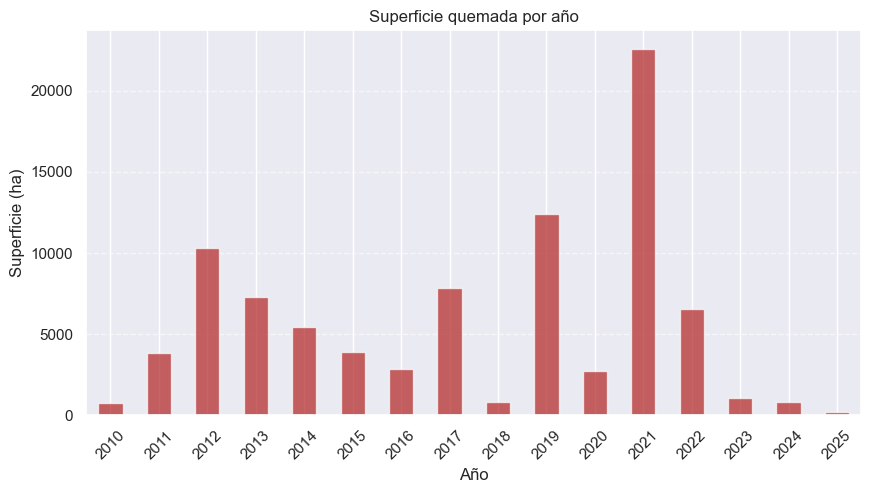

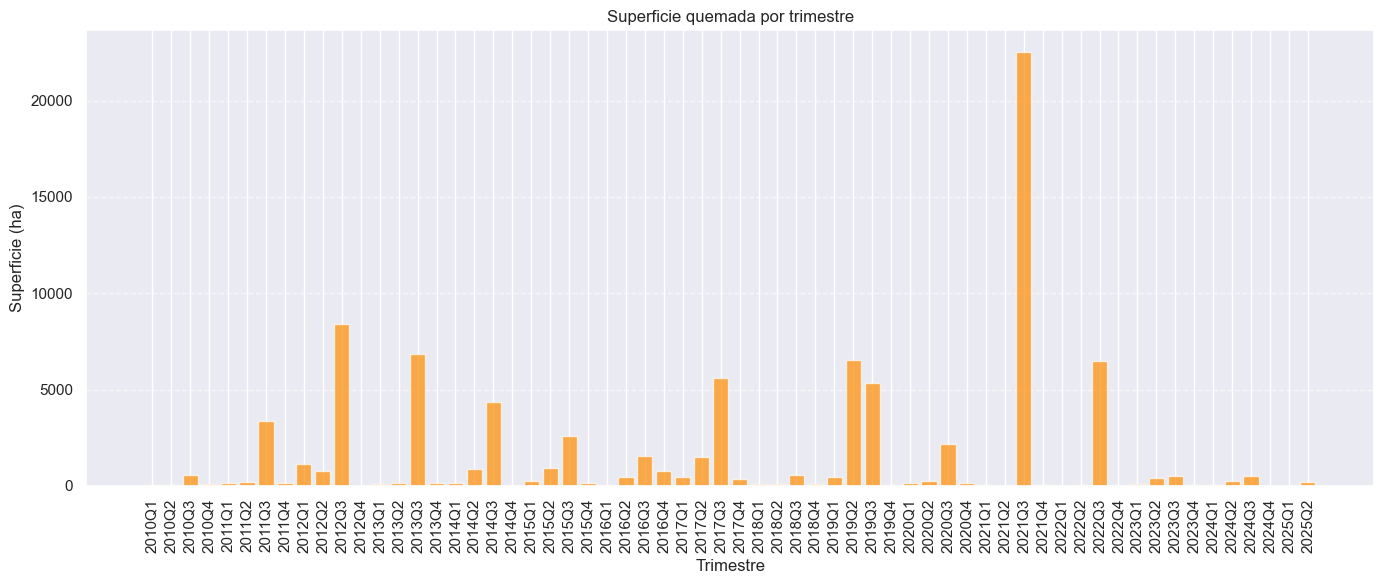

In [53]:
# 🔹 Incendios por AÑO
# =======================
df_year = df_incendios_def.groupby(df_incendios_def["DIA/MES/ANO"].dt.year)["Superficie_incendiada_HA"].sum()

plt.figure(figsize=(10,5))
df_year.plot(kind="bar", color="firebrick", alpha=0.7)
plt.title("Superficie quemada por año")
plt.ylabel("Superficie (ha)")
plt.xlabel("Año")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# =======================
# 🔹 Incendios por TRIMESTRE
# =======================

# Agrupar por trimestre y sumar la superficie
df_quarter = (
    df_incendios_def
      .groupby(pd.Grouper(key="DIA/MES/ANO", freq="QE"))["Superficie_incendiada_HA"]
      .sum()
      .reset_index()
)

# Crear etiqueta tipo "Q1 2010"
df_quarter["Periodo"] = df_quarter["DIA/MES/ANO"].dt.to_period("Q").astype(str)

# Graficar
plt.figure(figsize=(14,6))
plt.bar(df_quarter["Periodo"], df_quarter["Superficie_incendiada_HA"], 
        color="darkorange", alpha=0.7)

plt.title("Superficie quemada por trimestre")
plt.ylabel("Superficie (ha)")
plt.xlabel("Trimestre")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

A simple vista parece que los datos predecidos son coherentes, por tanto, exporto base de datos

In [54]:
df_incendios_def.to_parquet("04_DATASET_INCENDIOS.parquet", index=False)